In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3a
commitnumber = 5014a19
conc = None
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0, 0]
ng_refs = [2, 6]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 300
vmax = 620
vmin = 540
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

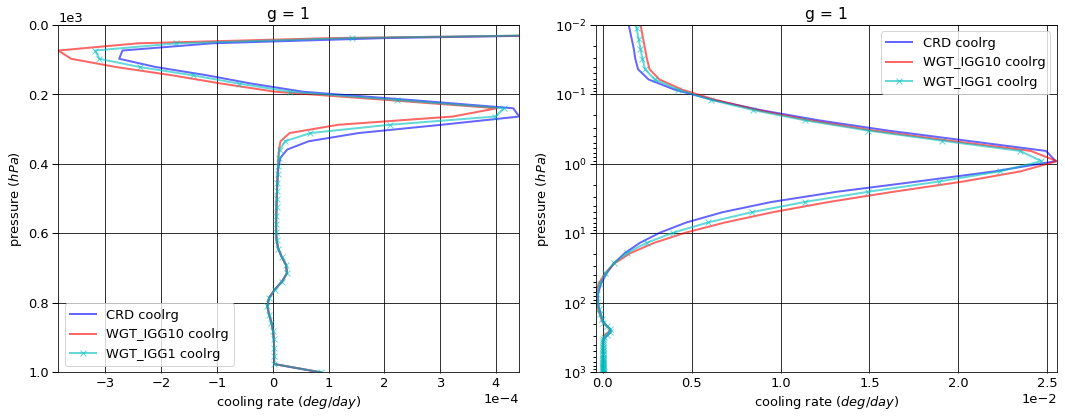

# Figure: cooling rate g-group 2

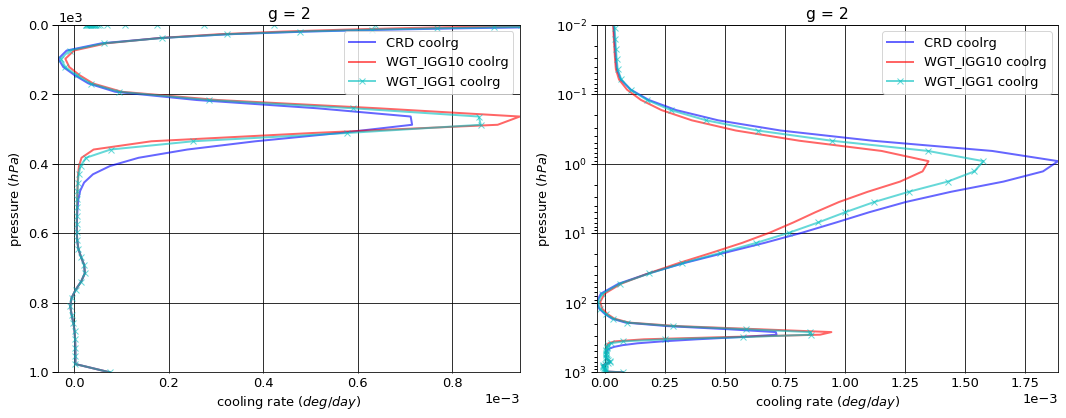

# Figure: cooling rate g-group 3

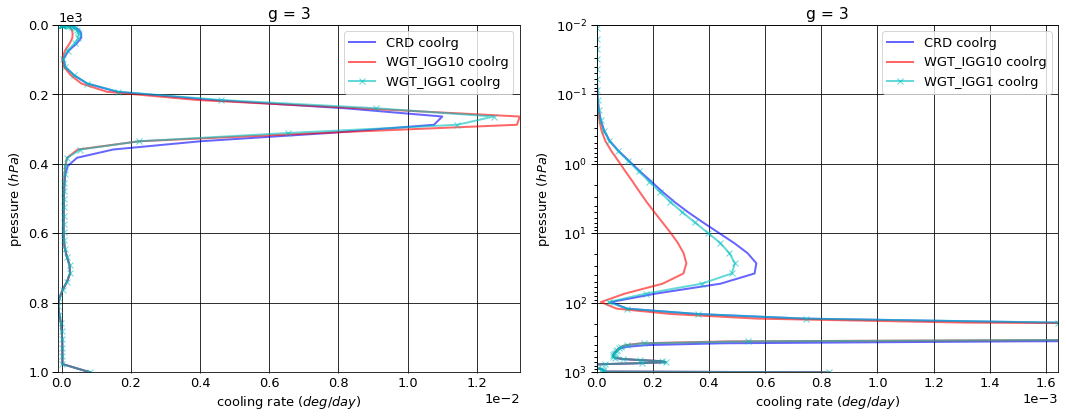

# Figure: cooling rate g-group 4

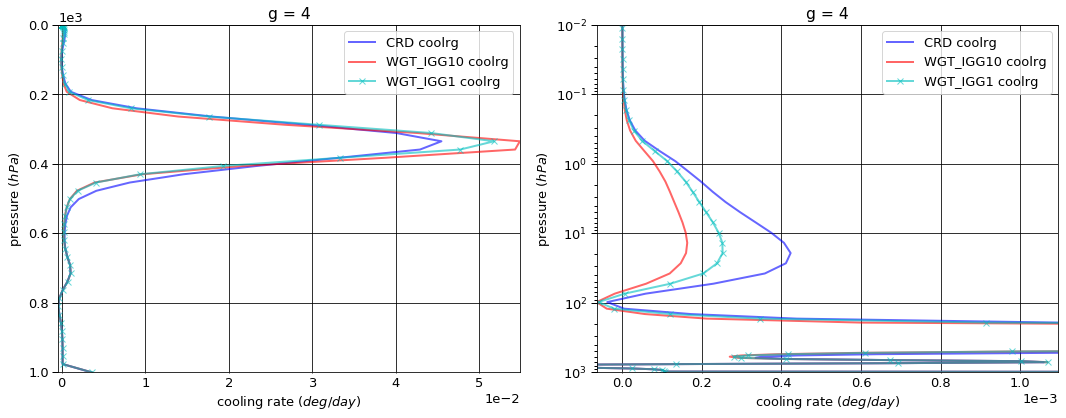

# Figure: cooling rate g-group 5

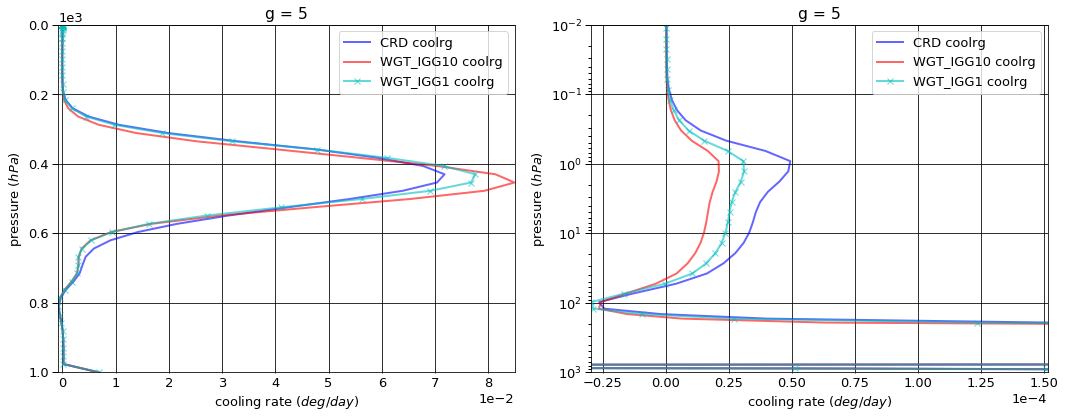

# Figure: cooling rate g-group 6

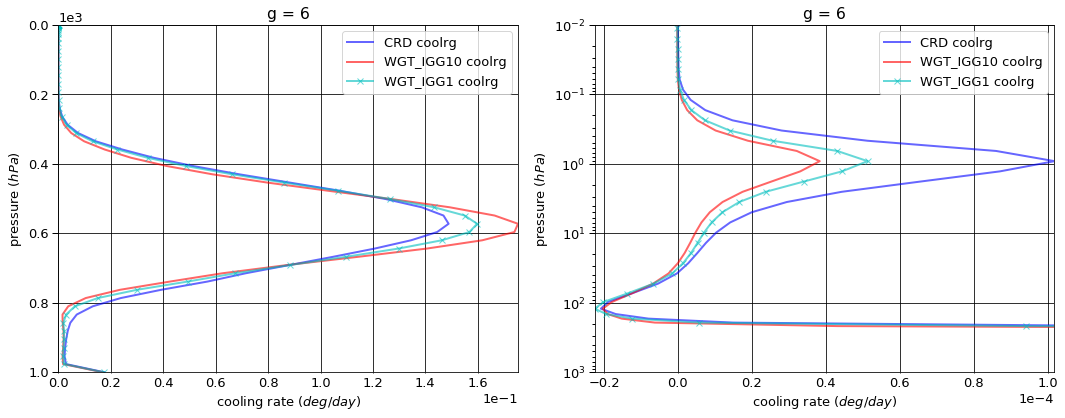

# Figure: cooling rate g-group 7

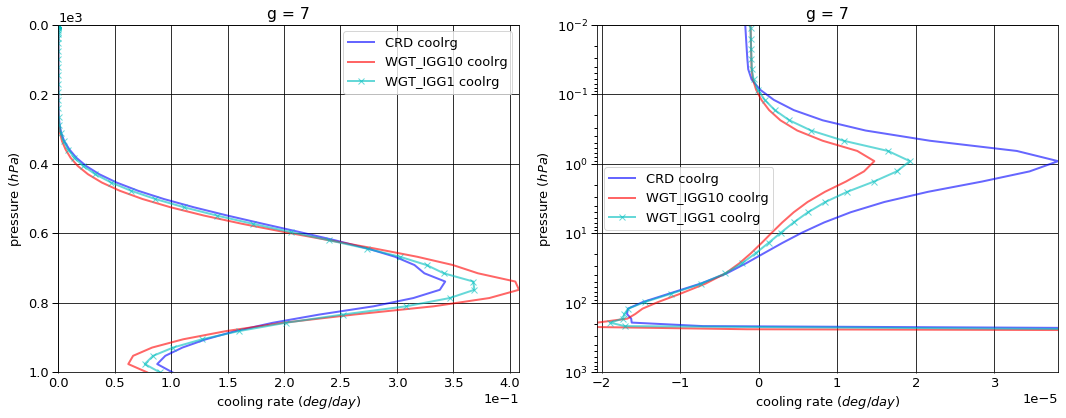

# Figure: cooling rate g-group 8

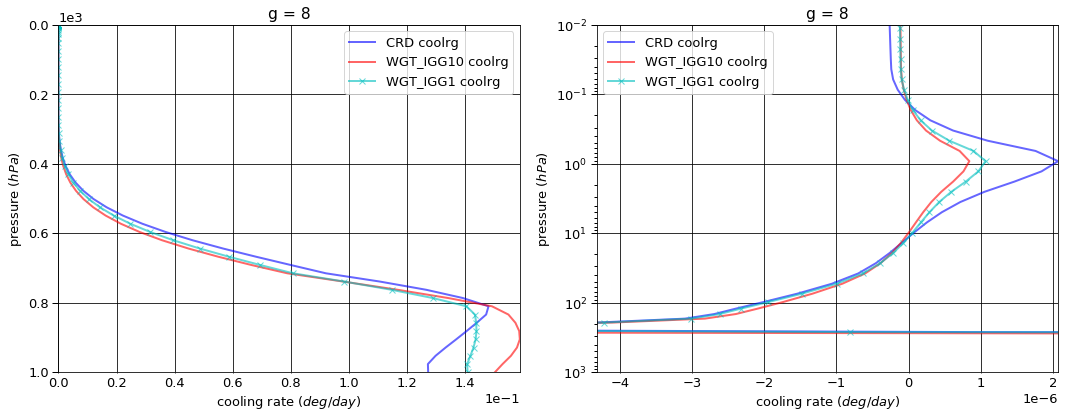

# Figure: cooling rate g-group total

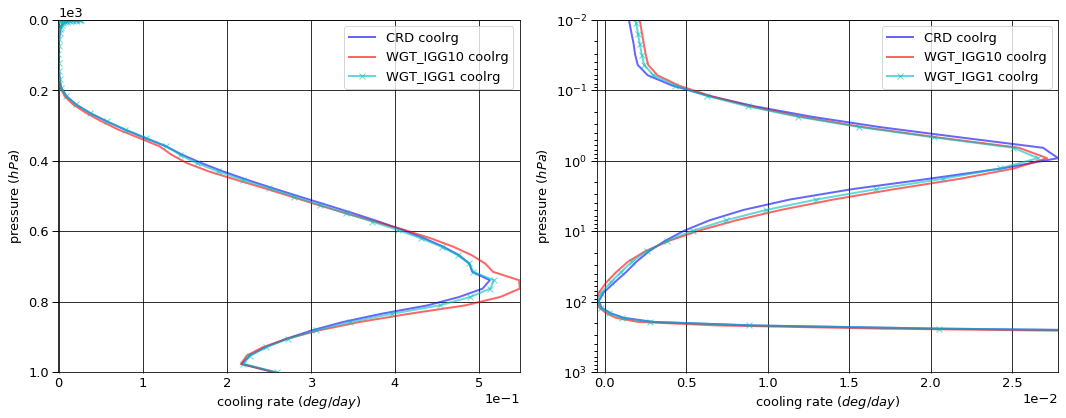

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.017374   0.000000  -0.017374
  1013.0   76     -0.038493   0.038258  -0.000235
2 0.0      1      -0.014145   0.000000  -0.014145
  1013.0   76     -0.033677   0.033469  -0.000208
3 0.0      1      -0.156309   0.000000  -0.156309
  1013.0   76     -0.370460   0.368192  -0.002268
4 0.0      1      -0.815789   0.000000  -0.815789
  1013.0   76     -1.606772   1.596920  -0.009851
5 0.0      1      -1.849892   0.000000  -1.849892
  1013.0   76     -3.058680   3.039943  -0.018736
6 0.0      1      -5.132300   0.000000  -5.132300
  1013.0   76     -7.233708   7.182163  -0.051545
7 0.0      1     -14.139447   0.000000 -14.139447
  1013.0   76    -17.358197  16.769805  -0.588392
8 0.0      1      -7.884522   0.000000  -7.884522
  1013.0   76     -8.791748   6.802834  -1.988914


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.017548   0.000000  -0.017548
  1013.0   76     -0.038786   0.038546  -0.000240
2 0.0      1      -0.013573   0.000000  -0.013573
  1013.0   76     -0.033672   0.033463  -0.000208
3 0.0      1      -0.156165   0.000000  -0.156165
  1013.0   76     -0.372531   0.370229  -0.002302
4 0.0      1      -0.818912   0.000000  -0.818912
  1013.0   76     -1.614552   1.604573  -0.009979
5 0.0      1      -1.866324   0.000000  -1.866324
  1013.0   76     -3.076426   3.057412  -0.019014
6 0.0      1      -5.157424   0.000000  -5.157424
  1013.0   76     -7.275266   7.227662  -0.047604
7 0.0      1     -14.208523   0.000000 -14.208523
  1013.0   76    -17.400870  17.057864  -0.343005
8 0.0      1      -7.869532   0.000000  -7.869532
  1013.0   76     -8.679632   6.800589  -1.879043


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.017365   0.000000  -0.017365
  1013.0   76     -0.038786   0.038546  -0.000240
2 0.0      1      -0.013739   0.000000  -0.013739
  1013.0   76     -0.033672   0.033463  -0.000208
3 0.0      1      -0.153288   0.000000  -0.153288
  1013.0   76     -0.372531   0.370229  -0.002302
4 0.0      1      -0.807360   0.000000  -0.807360
  1013.0   76     -1.614552   1.604573  -0.009979
5 0.0      1      -1.840749   0.000000  -1.840749
  1013.0   76     -3.076426   3.057413  -0.019014
6 0.0      1      -5.132148   0.000000  -5.132148
  1013.0   76     -7.275266   7.226213  -0.049053
7 0.0      1     -14.174494   0.000000 -14.174494
  1013.0   76    -17.400870  16.973104  -0.427766
8 0.0      1      -7.860304   0.000000  -7.860304
  1013.0   76     -8.679632   6.566377  -2.113255


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000175  0.000000 -1.745160e-04
  1013.0   76    -0.000292  0.000288 -4.801170e-06
2 0.0      1      0.000571  0.000000  5.711230e-04
  1013.0   76     0.000005 -0.000005  9.141000e-08
3 0.0      1      0.000144  0.000000  1.439300e-04
  1013.0   76    -0.002071  0.002037 -3.397030e-05
4 0.0      1     -0.003122  0.000000 -3.122340e-03
  1013.0   76    -0.007780  0.007653 -1.274418e-04
5 0.0      1     -0.016432  0.000000 -1.643160e-02
  1013.0   76    -0.017747  0.017469 -2.775070e-04
6 0.0      1     -0.025125  0.000000 -2.512470e-02
  1013.0   76    -0.041558  0.045499  3.941007e-03
7 0.0      1     -0.069076  0.000000 -6.907600e-02
  1013.0   76    -0.042673  0.288059  2.453870e-01
8 0.0      1      0.014990  0.000000  1.498990e-02
  1013.0   76     0.112116 -0.002245  1.098707e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000009  0.000000  9.082000e-06
  1013.0   76    -0.000292  0.000288 -4.801170e-06
2 0.0      1      0.000405  0.000000  4.053070e-04
  1013.0   76     0.000005 -0.000005  9.141000e-08
3 0.0      1      0.003021  0.000000  3.020910e-03
  1013.0   76    -0.002071  0.002037 -3.397030e-05
4 0.0      1      0.008430  0.000000  8.429540e-03
  1013.0   76    -0.007780  0.007653 -1.274418e-04
5 0.0      1      0.009143  0.000000  9.142800e-03
  1013.0   76    -0.017747  0.017469 -2.775010e-04
6 0.0      1      0.000151  0.000000  1.514000e-04
  1013.0   76    -0.041558  0.044050  2.492170e-03
7 0.0      1     -0.035047  0.000000 -3.504700e-02
  1013.0   76    -0.042673  0.203299  1.606266e-01
8 0.0      1      0.024218  0.000000  2.421840e-02
  1013.0   76     0.112116 -0.236457 -1.243415e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      5.825546e-04
  1001.112500 75     8.447948e-05
2 0.000312    1      2.113560e-05
  1001.112500 75     7.485625e-05
3 0.000312    1      3.570549e-09
  1001.112500 75     8.157357e-04
4 0.000312    1      2.490010e-07
  1001.112500 75     3.542440e-03
5 0.000312    1      1.035103e-07
  1001.112500 75     6.737841e-03
6 0.000312    1     -2.008123e-07
  1001.112500 75     1.756455e-02
7 0.000312    1     -2.231835e-06
  1001.112500 75     1.010480e-01
8 0.000312    1     -2.969976e-07
  1001.112500 75     1.272067e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.360733e-03
  1001.112500 75     8.618801e-05
2 0.000312    1      2.105947e-05
  1001.112500 75     7.482380e-05
3 0.000312    1      1.869894e-09
  1001.112500 75     8.278252e-04
4 0.000312    1      1.148099e-07
  1001.112500 75     3.587798e-03
5 0.000312    1     -3.051271e-08
  1001.112500 75     6.836330e-03
6 0.000312    1     -2.568784e-07
  1001.112500 75     1.700239e-02
7 0.000312    1     -1.216402e-06
  1001.112500 75     7.861267e-02
8 0.000312    1     -1.278268e-07
  1001.112500 75     1.501468e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.104135e-03
  1001.112500 75     8.618801e-05
2 0.000312    1      2.431251e-05
  1001.112500 75     7.482380e-05
3 0.000312    1      3.113864e-09
  1001.112500 75     8.278252e-04
4 0.000312    1      2.239055e-07
  1001.112500 75     3.587798e-03
5 0.000312    1      1.519632e-08
  1001.112500 75     6.836323e-03
6 0.000312    1     -2.459870e-07
  1001.112500 75     1.731066e-02
7 0.000312    1     -1.299690e-06
  1001.112500 75     8.989797e-02
8 0.000312    1     -1.383940e-07
  1001.112500 75     1.407573e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      7.781785e-04
  1001.112500 75     1.708526e-06
2 0.000312    1     -7.612900e-08
  1001.112500 75    -3.245100e-08
3 0.000312    1     -1.700654e-09
  1001.112500 75     1.208948e-05
4 0.000312    1     -1.341911e-07
  1001.112500 75     4.535840e-05
5 0.000312    1     -1.340230e-07
  1001.112500 75     9.848900e-05
6 0.000312    1     -5.606606e-08
  1001.112500 75    -5.621590e-04
7 0.000312    1      1.015433e-06
  1001.112500 75    -2.243531e-02
8 0.000312    1      1.691709e-07
  1001.112500 75     2.294011e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.215804e-04
  1001.112500 75     1.708526e-06
2 0.000312    1      3.176916e-06
  1001.112500 75    -3.245100e-08
3 0.000312    1     -4.566851e-10
  1001.112500 75     1.208948e-05
4 0.000312    1     -2.509553e-08
  1001.112500 75     4.535840e-05
5 0.000312    1     -8.831395e-08
  1001.112500 75     9.848210e-05
6 0.000312    1     -4.517467e-08
  1001.112500 75    -2.538880e-04
7 0.000312    1      9.321448e-07
  1001.112500 75    -1.115001e-02
8 0.000312    1      1.586037e-07
  1001.112500 75     1.355062e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.009778,0.000000,-30.009778
1013.0,76,-38.491734,35.831584,-2.660150



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.108002,0.000000,-30.108002
1013.0,76,-38.491735,36.190339,-2.301395



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.999447,0.000000,-29.999447
1013.0,76,-38.491735,35.869918,-2.621816



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-9.822420e-02,0.000000,-0.098224
1013.0,76,-5.160000e-07,0.358755,0.358755



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.033044e-02,0.000000,0.010330
1013.0,76,-5.160000e-07,0.038334,0.038334


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000601
1001.112500,75,0.257075



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001380
1001.112500,75,0.257175



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.001127
1001.112500,75,0.259379



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000779
1001.112500,75,0.000100



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000526
1001.112500,75,0.002304


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001000,0.001008
2,0.000875,0.000875
3,0.009625,0.009678
4,0.041750,0.041945
5,0.079500,0.079924
6,0.188000,0.189009
7,0.451000,0.452068
8,0.228250,0.225493


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.010748e-19
2,1.113475e-20
3,5.547258e-21
4,1.024886e-21
5,1.893533e-22
6,3.498405e-23
7,6.463493e-24
8,1.194165e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.010748e-19,NaN,0.001000,0.001008,0.001000,0.001008,10.0
2,1.113475e-20,0.110164,0.000875,0.000875,0.001875,0.001882,10.0
3,5.547258e-21,0.498193,0.009625,0.009678,0.011500,0.011561,600.0
4,1.024886e-21,0.184755,0.041750,0.041945,0.053250,0.053506,600.0
5,1.893533e-22,0.184755,0.079500,0.079924,0.132750,0.133430,600.0
6,3.498405e-23,0.184755,0.188000,0.189009,0.320750,0.322439,600.0
7,6.463493e-24,0.184755,0.451000,0.452068,0.771750,0.774507,600.0
8,1.194165e-24,0.184755,0.228250,0.225493,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
